# Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import json
from datetime import datetime

# Base de dados

In [4]:
df = pd.read_excel('../Base120.xlsx')

In [63]:
def filtra_por_solucao(df, vet_solucao):
    '''Recebe um vetor solução e retorna o df filtrado para essa solução'''
    stand_prescription_map = {i + 1: vet_solucao[i] for i in range(len(vet_solucao))}
    filtered_df = df[df.apply(lambda row: row['prescrição'] == stand_prescription_map.get(row['talhao']), axis=1)]
    return filtered_df

def calcula_volume(result):
	"""
	Calculate the volume by summing specific columns of a DataFrame.
	This function takes a DataFrame `result` and returns the sum of the values
	in columns 3 to 18 (inclusive).
	Parameters:
	result (pandas.DataFrame): The input DataFrame containing the data.
	Returns:
	pandas.Series: A Series containing the sum of the specified columns.
	"""
	
    
	return result.iloc[:, 3:19].sum()

def calcula_penalidade(volume_anual):
    '''retorna penalidade por volume excedente/faltante (R$500)'''
    upper = []
    lower = []
    for v_ano in volume_anual:
        if v_ano < 140000:
            lower.append(np.abs(v_ano - 140000))
        elif v_ano > 160000:
            upper.append(np.abs(v_ano - 160000))
    return np.sum(upper + lower)*500

def calcula_vpl_aux(result, volume_ano):
    '''Calcula o VPL penalizado (função auxiliar)'''
    return np.sum(result['VPL']) - calcula_penalidade(volume_ano)

def plota_volume(df, vet_sol):
    '''Plota o gráfico do volume nos anos'''
    volume_ano = filtra_por_solucao(df, vet_sol).iloc[:, 3:19].sum()
    (volume_ano/1000).plot(kind='bar')
    plt.hlines(140, xmin=-1, xmax=16, color='red', alpha=.6)
    plt.hlines(160, xmin=-1, xmax=16, color='red', alpha=.6)
    plt.title("Volume de madeira por ano")
    plt.xlabel("Ano de Produção")
    plt.ylabel("Volume (1000 m$^3$)")

def calcula_volume_aux(df, vet_sol):
	"""
	Calculate the auxiliary volume based on the given solution vector.
	This function filters the DataFrame `df` using the solution vector `vet_sol`
	and then sums the values in columns 3 to 18 (inclusive) of the filtered DataFrame.
	Parameters:
	df (pandas.DataFrame): The input DataFrame containing the data.
	vet_sol (list or array-like): The solution vector used to filter the DataFrame.
	Returns:
	pandas.Series: A Series containing the sum of the values in columns 3 to 18 of the filtered DataFrame.
	"""
    
	return filtra_por_solucao(df, vet_sol).iloc[:, 3:19].sum()

def calcula_vpl_total(df, vet_solucao):
    '''Calcula o VPL total penalizado'''
    result = filtra_por_solucao(df, vet_solucao)
    volume_ano = calcula_volume(result)
    return calcula_vpl_aux(result, volume_ano)

def encontra_pior_ano(df, sol):
    volume_ano = calcula_volume_aux(df, sol)
    return np.argmax(np.abs(volume_ano-160000)) + 1

def numpy_to_python(obj):
    '''Converte np.int e np.float para int e float dos dados do dicionário'''
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    
def python_to_numpy(dicionario):
    '''Converte int e float para np.int e np.float dos dados do dicionário'''
    for chave, subdict in dicionario.items():
        for subchave, valor in subdict.items():
            if isinstance(valor, int):
                subdict[subchave] = np.int64(valor)
            elif isinstance(valor, float):
                subdict[subchave] = np.float64(valor)
                
    dicionario = {np.int64(key): valor for key, valor in dicionario.items()}
    return dicionario

---

## Alteração na base de dados

In [5]:
df_2 = df.drop_duplicates(subset=['talhao'] + df.columns[3:].tolist(), keep='first')
df_2.to_csv('../base_reduzida.csv', index=False)

# Busca Local

Sorteie um dos 120 talhões e gera os vizinhos para todas suas precrições, alterando a solução atual para o melhor vizinho e repetindo o processo.

## Soluções importadas


In [51]:
with open("solucoes_alpha.json", "r") as arquivo: # soluções geradas por heurística construtiva
    solucoes_alpha = json.load(arquivo)
solucoes_alpha = [np.array(sol) for sol in solucoes_alpha]

In [52]:
import random
import matplotlib.ticker as ticker

def gera_vizinhos(df, vet_solucao):
    """
    Gera vizinhos de um talhão sorteado
    """
    vizinhos = []
    talhao_sorteado = random.randint(0, 119)
    prescricoes_talhao = df[df['talhao'] == talhao_sorteado+1]['prescrição'].unique() # prescrições únicas de cada talhão
    for prescricao in prescricoes_talhao:
        vizinho = vet_solucao.copy()
        vizinho[talhao_sorteado] = prescricao # altera solução
        vizinhos.append(vizinho)
    return vizinhos

def gera_vizinhos_localizado(df, solucao):
    """
    Gera uma lista de vizinhos localizados para uma solução dada.
    Esta função identifica o pior ano em uma solução e, em seguida, encontra
    todos os talhões que podem ser colhidos naquele ano com base nas idades
    de colheita fornecidas.
    Args:
        df (pd.DataFrame): DataFrame contendo informações sobre os talhões,
                             incluindo a idade de cada talhão.
        solucao (list): Lista representando a solução atual.
        idade_colheita (dict): Dicionário onde as chaves são anos e os valores
                               são listas de idades possíveis para colheita
                               naquele ano.
    Returns:
        None: A função imprime o pior ano e os talhões possíveis para colheita
              naquele ano.
    """
    
    idade_colheita = {1: ['5', '6'],
                  2: ['4', '5', '6'],
				  3: ['3', '4', '5'],
				  4: ['2', '3', '4'],
				  5: ['1', '2', '3'],
				  6: ['1', '2', '5', '6'],
				  7: ['1', '4', '5', '6'],
				  8: ['3', '4', '5', '6'],
				  9: ['2', '3', '4', '5', '6'],
				  10: ['1', '2', '3', '4', '5'],
				  11: ['1', '2', '3', '4', '5', '6'],
				  12: ['1', '2', '3', '4', '5', '6'],
				  13: ['1', '2', '3', '4', '5', '6'],
				  14: ['1', '2', '3', '4', '5', '6'],
				  15: ['1', '2', '3', '4', '5', '6'],
				  16: ['1', '2', '3', '4', '5', '6']}
    pior_ano = encontra_pior_ano(df, solucao)
    possiveis_idades = idade_colheita[pior_ano]
    possiveis_talhoes = df[np.isin(df.loc[:, 'idade'], list(map(int, possiveis_idades)))]['talhao'].unique() # talhoes que podem fazer colheita naquele ano
    talhao_sorteado = random.sample(list(possiveis_talhoes), 1)
    vizinhos = []
    prescricoes_talhao = df[df['talhao'] == talhao_sorteado[0]]['prescrição'].unique() # prescrições únicas de cada talhão
    
    for prescricao in prescricoes_talhao:
        vizinho = solucao.copy()
        vizinho[talhao_sorteado[0]-1] = prescricao # altera solução
        vizinhos.append(vizinho)
    return vizinhos

def gera_vizinhos_sistematico(df, sol):
    """
    Gera vizinhos sistemáticos para uma solução dada.
    Parâmetros:
    df (pandas.DataFrame): DataFrame contendo os dados com colunas 'talhao' e 'prescrição'.
    sol (numpy.ndarray): Array representando a solução atual.
    Retorna:
    numpy.ndarray: Array de vizinhos gerados sistematicamente.
    """
    
    # Gera 120 vizinhos com talhões alterados sistematicamente para um prescrição aleatória
    vizinhos = np.tile(sol, (120, 1))
    for pos, vizinho in enumerate(vizinhos):
        prescricoes = df[df['talhao'] == pos + 1]['prescrição'].unique()
        vizinho[pos] = random.choice(prescricoes)
        
    return vizinhos

def varre_vizinhos(vizinhos, sol_atual, df, metodo, max_calculos_obj):
    """
    Returns the neighbor with the highest VPL.
    """
    max_vpl = calcula_vpl_total(df, sol_atual)  # Initialize with negative infinity to ensure the first neighbor is considered
    melhor_vizinho = sol_atual
    count_calculos_obj = 0

    for vizinho in vizinhos:
        if count_calculos_obj >= max_calculos_obj: # não entra na primeira iteração
            break
        
        vpl_atual = calcula_vpl_total(df, vizinho)
        count_calculos_obj += 1
        
        if metodo=='mm': # melhor melhor
            if vpl_atual > max_vpl:
                max_vpl = vpl_atual
                melhor_vizinho = vizinho
        elif metodo=='pm': # primeiro melhor
            if vpl_atual > max_vpl:
                max_vpl = vpl_atual
                melhor_vizinho = vizinho
                break

    return melhor_vizinho, count_calculos_obj  # Return the neighbor with the highest VPL

def busca_local(df, sol_atual, tempo_max=np.inf, max_calculos_obj=np.inf, seed=42, metodo='mm', vizinhanca='aleatoria'):
    inicio = time.time()
    counter_melhor_vizinho, counter_nova_solucao, counter_quant_sol, counter_calculos_obj = 0, 0, 0, 0
    melhores_vpl = []
    random.seed(seed)

    while True:
        if time.time() - inicio > tempo_max or (tempo_max == np.inf and counter_calculos_obj >= max_calculos_obj): # critérios de parada
            print("Tempo máximo atingido")
            break
        
        # gera diferentes vizinhanças 
        if vizinhanca=='aleatoria':
            vizinhos_sol_atual = gera_vizinhos(df, sol_atual)
        elif vizinhanca=='localizada':
            vizinhos_sol_atual = gera_vizinhos_localizado(df, sol_atual)
        elif vizinhanca=='sistematica':
            vizinhos_sol_atual = gera_vizinhos_sistematico(df, sol_atual)
            
        counter_calculos_obj_aux = 0
        melhor_vizinho, counter_calculos_obj_aux = varre_vizinhos(vizinhos_sol_atual, sol_atual, df, metodo=metodo, max_calculos_obj=max_calculos_obj)
        counter_calculos_obj += counter_calculos_obj_aux

        if all(melhor_vizinho == sol_atual): # nunhum vizinho melhor
            counter_nova_solucao +=1
        else:
            sol_atual = melhor_vizinho
            melhores_vpl.append(calcula_vpl_total(df, sol_atual))
            counter_melhor_vizinho += 1
            counter_quant_sol += 1

    print(counter_melhor_vizinho, ' trocas para melhor vizinho')
    print(counter_nova_solucao, ' trocas para nova solução')
    return (calcula_vpl_total(df, sol_atual), sol_atual)

In [53]:
calcula_vpl_total(df_2, solucoes_alpha[2])

np.int64(-54932408)

---

In [54]:
class experimento:
    """
    Classe para realizar experimentos e calcular estatísticas sobre os resultados.
    Atributos:
    ----------
    resultados : dict
        Dicionário contendo os resultados dos experimentos.
    media : float
        Média dos resultados.
    maximo : float
        Valor máximo dos resultados.
    minimo : float
        Valor mínimo dos resultados.
    std : float
        Desvio padrão dos resultados.
    estatisticas : dict
        Dicionário contendo as estatísticas calculadas para cada número de cálculos de função objetivo.
    Métodos:
    --------
    __init__(self, resultados):
        Inicializa a classe com os resultados fornecidos.
    calcula_estatisticas(self):
        Calcula as estatísticas (média, máximo, mínimo e desvio padrão) para os resultados fornecidos.
    plota_experimento(self, medida='media'):
        Plota os resultados do experimento com base na medida especificada (padrão é 'media').
    """
    def __init__(self, resultados):
        self.num_calculos_obj = [5000, 10000, 25000, 50000]
        self.resultados = resultados
        self.media = 0
        self.maximo = 0
        self.minimo = 0
        self.std = 0
        self.estatisticas = {num: {'mm': {'media': self.media, 
                                          'maximo': self.maximo, 
                                          'minimo': self.minimo,
                                          'std': self.std},
                                   'pm': {'media': self.media, 
                                          'maximo': self.maximo, 
                                          'minimo': self.minimo,
                                          'std': self.std}} for num in self.num_calculos_obj}
    
    def calcula_estatisticas(self):
        for max_calc, inner in self.resultados.items():
            for k, v in inner.items():
                self.estatisticas[max_calc][k]['media'] = np.mean(v)
                self.estatisticas[max_calc][k]['maximo'] = np.max(v)
                self.estatisticas[max_calc][k]['minimo'] = np.min(v)
                self.estatisticas[max_calc][k]['std'] = np.std(v)
                
    def plota_experimento(self, medida='media'):
        x = self.estatisticas.keys()
        medias_mm = []
        medias_pm = []
        for _, inner_dict in self.estatisticas.items():
            for metodo, v in inner_dict.items():
                if metodo == 'mm':
                    medias_mm.append(v[medida])
                if metodo == 'pm':
                    medias_pm.append(v[medida])

        plt.plot(x, medias_mm, '-o', label='MM')
        plt.plot(x, medias_pm, '-o', label='PM')
            
        plt.xlabel('Número cálculos função da objetivo')
        plt.ylabel('VPL')
        plt.title(f'VPL por número máximo de cálculos de função objetivo e vizinhança')
        plt.grid(True)
        plt.legend()
        plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
        plt.ticklabel_format(style='plain', axis='x') 

In [55]:
num_calculos_obj = [5000, 10000, 25000, 50000]
numero_rando_exp = range(15)

## Gerar vizinhança 1

In [56]:
start_time = datetime.now().strftime("%H:%M:%S")

v1_num_calc_vpl = {num: {'mm': [], 'pm': []} for num in num_calculos_obj}

for iter_experimento in numero_rando_exp:
    print(f'\nExperimento {iter_experimento} iniciado')
    for max_calculos_obj in v1_num_calc_vpl.items():
        print(f'\nNúmero de cálculos: {max_calculos_obj[0]}')
        calculos_dict = max_calculos_obj[1]
        
        vpl_busca_local, sol_busca_local = busca_local(df_2,
                                                    solucoes_alpha[2],
                                                    seed=iter_experimento,
                                                    max_calculos_obj=max_calculos_obj[0],
                                                        # tempo_max=10,
                                                    metodo='mm',
                                                    vizinhanca='aleatoria')
        print('Melhor melhor\nVPL: ', vpl_busca_local)
        calculos_dict['mm'].append(vpl_busca_local)

        vpl_busca_local, sol_busca_local = busca_local(df_2, 
                                                        solucoes_alpha[2], 
                                                        seed=iter_experimento,
                                                        max_calculos_obj=max_calculos_obj[0],
                                                        # tempo_max=109,
                                                        metodo='pm',
                                                        vizinhanca='aleatoria')
        calculos_dict['pm'].append(vpl_busca_local)
        print('Primeiro melhor\nVPL: ', vpl_busca_local)
        


Experimento 0 iniciado

Número de cálculos: 5000
Tempo máximo atingido
40  trocas para melhor vizinho
187  trocas para nova solução
Melhor melhor
VPL:  30058593.0
Tempo máximo atingido
75  trocas para melhor vizinho
199  trocas para nova solução
Primeiro melhor
VPL:  29113683

Número de cálculos: 10000
Tempo máximo atingido
53  trocas para melhor vizinho
405  trocas para nova solução
Melhor melhor
VPL:  30102541.0
Tempo máximo atingido
104  trocas para melhor vizinho
409  trocas para nova solução
Primeiro melhor
VPL:  29666728.0

Número de cálculos: 25000
Tempo máximo atingido
76  trocas para melhor vizinho
1070  trocas para nova solução
Melhor melhor
VPL:  30247150.0
Tempo máximo atingido
138  trocas para melhor vizinho
1077  trocas para nova solução
Primeiro melhor
VPL:  29918585.0

Número de cálculos: 50000
Tempo máximo atingido
76  trocas para melhor vizinho
2203  trocas para nova solução
Melhor melhor
VPL:  30247150.0
Tempo máximo atingido
139  trocas para melhor vizinho
2214  tr

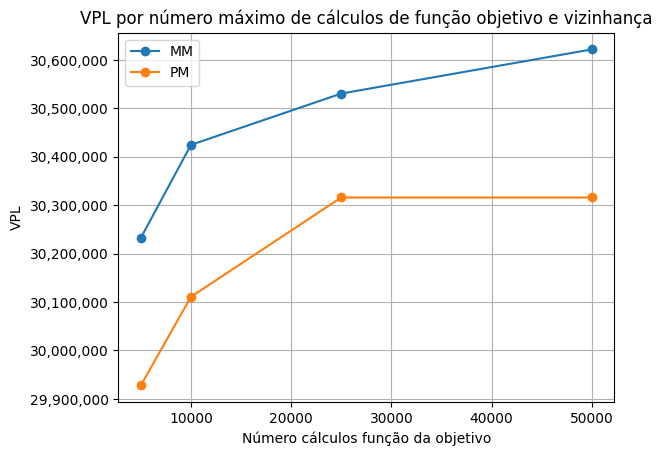

In [57]:
v1 = experimento(v1_num_calc_vpl)
v1.calcula_estatisticas()
v1.plota_experimento(medida='maximo')

In [67]:
caminho = 'bl_v1_experimentos.json'
with open(caminho, 'w', encoding='utf-8') as arquivo:
    json.dump(v1_num_calc_vpl, arquivo, ensure_ascii=False, indent=4, default=numpy_to_python)
    

{np.int64(5000): {'mm': [30058593.0,
   30077350.0,
   30096860.0,
   30025952.0,
   29970923.0,
   30173195.0,
   29833519.0,
   30136686.0,
   30232238.0,
   30164722.0,
   30105744.0,
   30089946.0,
   29972951.0,
   30050063.0,
   30063931],
  'pm': [29113683,
   29719455.0,
   29495841,
   29669983.0,
   29671067.0,
   29793338,
   29437417.0,
   29870961.0,
   29657809.0,
   29874244.0,
   29118359,
   29814693.0,
   29641312,
   29927680.0,
   29718945.0]},
 np.int64(10000): {'mm': [30102541.0,
   30140707.0,
   30340755.0,
   30265743.0,
   30036545.0,
   30330533.0,
   29951679.0,
   30242637.0,
   30424461.0,
   30302068.0,
   30378985.0,
   30270958.0,
   30153879.0,
   30153486.0,
   30336712.0],
  'pm': [29666728.0,
   29734241.0,
   30069223.0,
   29730697.0,
   29851315.0,
   29905729.0,
   29610254.0,
   30084122,
   29773356.0,
   30040639.0,
   29844081.0,
   29883683.0,
   30110594.0,
   30091248.0,
   29920838]},
 np.int64(25000): {'mm': [30247150.0,
   30234181.0,


---

## Gerar vizinhança 2

3 casos:

1. Dados o ano que mais acima da produção máxima, escolher dentro os talhões que podem fazer colheita nesse ano, escolher uma prescrição do melhor vizinho

2. Dados o ano que mais abaixo da produção mínima, escolher dentro os talhões que podem fazer colheita nesse ano, uma prescrição do melhor vizinho

3. Dados o ano dentro do limite e mais próximo da produção máxima, escolher dentro os talhões que podem fazer colheita nesse ano, escolher uma prescrição do melhor vizinho

In [58]:
v2_num_calc_vpl = {num: {'mm': [], 'pm': []} for num in num_calculos_obj}

for iter_experimento in numero_rando_exp:
    print(f'\nExperimento {iter_experimento} iniciado')
    for max_calculos_obj in v2_num_calc_vpl.items():
        print(f'\nNúmero de cálculos: {max_calculos_obj[0]}')
        calculos_dict = max_calculos_obj[1]
        
        vpl_busca_local, sol_busca_local = busca_local(df_2,
                                                    solucoes_alpha[2],
                                                    seed=iter_experimento,
                                                    max_calculos_obj=max_calculos_obj[0],
                                                        # tempo_max=10,
                                                    metodo='mm',
                                                    vizinhanca='localizada')
        print('Melhor melhor\nVPL: ', vpl_busca_local)
        calculos_dict['mm'].append(vpl_busca_local)

        vpl_busca_local, sol_busca_local = busca_local(df_2, 
                                                        solucoes_alpha[2], 
                                                        seed=iter_experimento,
                                                        max_calculos_obj=max_calculos_obj[0],
                                                        # tempo_max=109,
                                                        metodo='pm',
                                                        vizinhanca='localizada')
        calculos_dict['pm'].append(vpl_busca_local)
        print('Primeiro melhor\nVPL: ', vpl_busca_local)
    


Experimento 0 iniciado

Número de cálculos: 5000
Tempo máximo atingido
42  trocas para melhor vizinho
184  trocas para nova solução
Melhor melhor
VPL:  29974018.0
Tempo máximo atingido
108  trocas para melhor vizinho
185  trocas para nova solução
Primeiro melhor
VPL:  29711788.0

Número de cálculos: 10000
Tempo máximo atingido
65  trocas para melhor vizinho
392  trocas para nova solução
Melhor melhor
VPL:  30097464.0
Tempo máximo atingido
127  trocas para melhor vizinho
405  trocas para nova solução
Primeiro melhor
VPL:  29895838.0

Número de cálculos: 25000
Tempo máximo atingido
89  trocas para melhor vizinho
1056  trocas para nova solução
Melhor melhor
VPL:  30217842.0
Tempo máximo atingido
153  trocas para melhor vizinho
1077  trocas para nova solução
Primeiro melhor
VPL:  30152283.0

Número de cálculos: 50000
Tempo máximo atingido
89  trocas para melhor vizinho
2189  trocas para nova solução
Melhor melhor
VPL:  30217842.0
Tempo máximo atingido
153  trocas para melhor vizinho
2213 

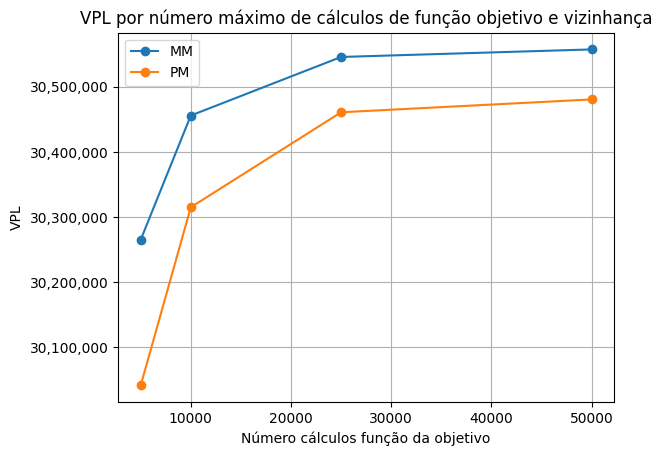

In [59]:
v2 = experimento(v2_num_calc_vpl)
v2.calcula_estatisticas()
v2.plota_experimento(medida='maximo')

In [68]:
caminho = 'bl_v2_experimentos.json'
with open(caminho, 'w', encoding='utf-8') as arquivo:
    json.dump(v2_num_calc_vpl, arquivo, ensure_ascii=False, indent=4, default=numpy_to_python)

---

## Gera vizinhanças 3

120 vizinhos compostos de uma troca sistematica de todos talhões por uma prescrição aleatória

In [ ]:
v3_num_calc_vpl = {num: {'mm': [], 'pm': []} for num in num_calculos_obj}

for iter_experimento in numero_rando_exp:
    print(f'\nExperimento {iter_experimento} iniciado')
    for max_calculos_obj in v3_num_calc_vpl.items():
        print(f'\nNúmero de cálculos: {max_calculos_obj[0]}')
        calculos_dict = max_calculos_obj[1]
        
        vpl_busca_local, sol_busca_local = busca_local(df_2,
                                                    solucoes_alpha[2],
                                                    seed=iter_experimento,
                                                    max_calculos_obj=max_calculos_obj[0],
                                                        # tempo_max=10,
                                                    metodo='mm',
                                                    vizinhanca='sistematica')
        print('Melhor melhor\nVPL: ', vpl_busca_local)
        calculos_dict['mm'].append(vpl_busca_local)

        vpl_busca_local, sol_busca_local = busca_local(df_2, 
                                                        solucoes_alpha[2], 
                                                        seed=iter_experimento,
                                                        max_calculos_obj=max_calculos_obj[0],
                                                        # tempo_max=109,
                                                        metodo='pm',
                                                        vizinhanca='sistematica')
        calculos_dict['pm'].append(vpl_busca_local)
        print('Primeiro melhor\nVPL: ', vpl_busca_local)

In [ ]:
caminho = 'bl_v3_experimentos.json'
with open(caminho, 'w', encoding='utf-8') as arquivo:
    json.dump(v2_num_calc_vpl, arquivo, ensure_ascii=False, indent=4, default=numpy_to_python)

In [ ]:
v3 = experimento(v3_num_calc_vpl)
v3.calcula_estatisticas()
v3.plota_experimento(medida='maximo')

In [ ]:
end_time = datetime.now().strftime("%H:%M:%S")

print(f'Inicio as {start_time}')
print(f'Inicio as {end_time}')